In [549]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm
import matplotlib.patheffects # for adding borders around text

import textwrap
import seaborn
import squarify

#import ttf_opensans

In [550]:
# set open sans as default font
mp.rcParams['font.family'] = 'Open Sans'

# gemplot variables

In [408]:
footer_color = "#222222"
footer_lineheight = 1.2
footer_fontsize = 14

# default height of a figure is 450 pixels

# gemstyle does this:
# specify a base_ratio, then set base_size = base_ratio*16
# 1. add 6 line margin all the way around
# 2. color of title is "#222222", margin 6666, size=base_size*1.5, lineheight=1.35, bold font
# 3. color of subtitle is "#333333", margin 0666, padding top=12, bottom=12, size=base_size*1.15, lineheight=1.45
# 4. set caption info as linehight=1.2, size=base_size*0.875, color="#222222", margin=18,6,6,6

base_ratio = 1.0
base_size = base_ratio * 16
color_title = "#222222"
color_subtitle = "#333333"
color_grid = "#cbcbcb"

text_weight_normal = 400
text_weight_bold = 700

# save fig
#' @keywords save_gem_plot
#' @examples
#' save_gem_plot(
#' plot_grid = line_plot_with_gem_footer,
#' save_filepath = "filename_that_my_plot_should_be_saved_to-nc.png",
#' width_pixels = 770,
#' height_pixels = 540,
#' resolution = 4
#' )
#'
#' @export
# save plot function - now separated from finalise_plot function and setting the resolution as part of the arguments
# save_gem_plot <- function (plot_grid, save_filepath, width_pixels = 640, height_pixels = 450, resolution = 3) {
#   grid::grid.draw(plot_grid)

#   #save it
#   ggplot2::ggsave(plot=plot_grid,
#                   width= (width_pixels/72),
#                   height= (height_pixels/72),
#                   dpi = resolution * 100,
#                   filename = save_filepath,
#                   bg="white")
# }

#width_pixels = 640 # default
#height_pixels = 450 # default

## define colors used in bars

In [409]:
# sel_cmap = matplotlib.colormaps['Reds']
# tracker_operating = sel_cmap(0.999)
# tracker_construction = sel_cmap(0.8)
# tracker_proposed = sel_cmap(0.6)
# tracker_shelved = sel_cmap(0.4)
# tracker_cancelled = sel_cmap(0.2)

tracker_construction = '#761200'
tracker_proposed = '#bf532c'
tracker_shelved = '#e3710c'
#tracker_cancelled = '#357a5d'
#tracker_cancelled = '#4e8a71'
tracker_cancelled = '#9abcae'

# import data directly from google sheets

In [410]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

pipes_df_orig = pandas.concat([gas_pipes, oil_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

In [411]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

In [412]:
status_list = ['Proposed', 
               'Construction', 
               'Shelved', 
               'Cancelled', 
               'Operating', 
               'Idle', 
               'Mothballed', 
               'Retired']
country_list = sorted(set(region_df_orig['Country'].tolist()))
region_list = sorted(set(region_df_orig['Region'].tolist()))
if '--' in region_list:
    region_list.remove('--')
subregion_list = sorted(set(region_df_orig['SubRegion'].tolist()))
if '--' in subregion_list:
    subregion_list.remove('--')

#country_list = sorted(list(set(terms_df_orig['Country'])))
#region_list = sorted(list(set(terms_df_orig['Region'])))

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [477]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']

missing_wiki_projectids = pipes_df_orig.loc[pipes_df_orig.Wiki==''].ProjectID.tolist()
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']

country_ratios_df.replace('--', numpy.nan, inplace=True)
country_ratios_df = country_ratios_df.loc[~country_ratios_df.ProjectID.isin(missing_wiki_projectids)]

# km by country, km by region calculations

In [478]:
dict_subregion_region = pandas.Series(region_df_orig.Region.values, index=region_df_orig.SubRegion).to_dict()
dict_subregion_region

{'Sub-Saharan Africa': 'Africa',
 'Northern Africa': 'Africa',
 'Latin America and the Caribbean': 'Americas',
 'Northern America': 'Americas',
 'Southern Asia': 'Asia',
 'Western Asia': 'Asia',
 'South-eastern Asia': 'Asia',
 'Eastern Asia': 'Asia',
 'Central Asia': 'Asia',
 'Northern Europe': 'Europe',
 'Southern Europe': 'Europe',
 'Western Europe': 'Europe',
 'Eastern Europe': 'Europe',
 'Polynesia': 'Oceania',
 'Australia and New Zealand': 'Oceania',
 'Melanesia': 'Oceania',
 'Micronesia': 'Oceania',
 '--': '--'}

In [479]:
region_df_orig_cleaned = region_df_orig.loc[(region_df_orig.Region!='--')&
                                            (region_df_orig.SubRegion!='--')]
multiindex_region_subregion = region_df_orig_cleaned.groupby(['Region','SubRegion'])['Country'].count().index
multiindex_region_subregion_country = region_df_orig_cleaned.groupby(['Region','SubRegion','Country'])['Country'].count().index

In [480]:
country_ratios_fuel_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    km_by_country_df[status] = country_ratios_fuel_df_status.groupby('Country')['MergedKmByCountry'].sum()
    km_by_subregion_df[status] = country_ratios_fuel_df_status.groupby(['Region','SubRegion'])['MergedKmByCountry'].sum()
    km_by_region_df[status] = country_ratios_fuel_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_subregion_df = km_by_subregion_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)
km_by_region_df = km_by_region_df.fillna(0)

#km_by_region_df.sort_index(level='Region', inplace=True)
#km_by_region_df = km_by_region_df.loc[~(km_by_region_df==0).all(axis=1)]

# total
# km_by_region_df.loc['Total',:] = km_by_region_df.sum(axis=0).values
# km_by_country_df.loc['Total',:] = km_by_country_df.sum(axis=0).values

km_by_subregion_df['Proposed+Construction'] = km_by_subregion_df[['Proposed','Construction']].sum(axis=1)
km_by_subregion_df = km_by_subregion_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]

km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)
km_by_country_df = km_by_country_df.loc[~(km_by_country_df==0).all(axis=1)]
km_by_country_df.loc[:,'Region'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].Region
km_by_country_df.loc[:,'Subregion'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].SubRegion
km_by_country_df = km_by_country_df[['Region','Subregion','Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df = km_by_country_df.loc[(km_by_country_df.Region!='--')&
                                        (km_by_country_df.Subregion!='--')]

km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]

km_by_subregion_df.index.set_names(['Region','Subregion'], inplace=True)
km_by_subregion_df.loc['Total',:] = km_by_subregion_df.sum(axis=0).values
km_by_subregion_df.replace(0,'', inplace=False)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


Proposed Construction  \
Region   Subregion                                                  
Africa   Northern Africa                   4,072.700      187.930   
         Sub-Saharan Africa               18,561.800    1,582.000   
Americas Latin America and the Caribbean  17,090.970    2,170.000   
         Northern America                  8,571.630    2,515.840   
Asia     Central Asia                      3,867.220    1,604.330   
         Eastern Asia                     37,446.810   30,365.160   
         South-eastern Asia                8,849.030    1,087.300   
         Southern Asia                    12,731.610   22,425.640   
         Western Asia                      6,015.840    2,153.520   
Europe   Eastern Europe                   21,303.580    3,830.210   
         Northern Europe                   1,111.490        1.200   
         Southern Europe                   8,526.750    1,656.290   
         Western Europe                      708.300       82.000   
Oceania  Australia and New Zealand         9,856.640        4.300   
         Melanesia                           320.000                
         Micronesia                                                 
         Polynesia                                                  
Total                                    159,034.370   69,665.720   

                                         Proposed+Construction    Shelved  \
Region   Subregion                                                          
Africa   Northern Africa                             4,260.630    172.210   
         Sub-Saharan Africa                         20,143.800  1,319.720   
Americas Latin America and the Caribbean            19,260.970  3,097.050   
         Northern America                           11,087.470  3,456.390   
Asia     Central Asia                                5,471.550              
         Eastern Asia                               67,811.970  1,784.070   
         South-eastern Asia                          9,936.330  2,712.410   
         Southern Asia                              35,157.250  1,752.000   
         Western Asia                                8,169.360  1,845.760   
Europe   Eastern Europe                             25,133.790  4,553.920   
         Northern Europe                             1,112.690  1,000.000   
         Southern Europe                            10,183.040    764.540   
         Western Europe                                790.300     69.250   
Oceania  Australia and New Zealand                   9,860.940  3,726.220   
         Melanesia                                     320.000    400.000   
         Micronesia                                                         
         Polynesia                                                          
Total                                              228,700.090 26,653.540   

                                          Cancelled     Operating      Idle  \
Region   Subregion                                                            
Africa   Northern Africa                    589.000    24,859.700             
         Sub-Saharan Africa                 228.960     7,141.520             
Americas Latin America and the Caribbean  2,344.660    59,836.280   331.000   
         Northern America                20,654.810   401,851.870    50.000   
Asia     Central Asia                     2,590.590    29,099.490             
         Eastern Asia                     2,827.380   127,567.050             
         South-eastern Asia               1,329.000    17,665.110             
         Southern Asia                   10,509.970    39,861.300             
         Western Asia                     9,827.630    36,466.830             
Europe   Eastern Europe                   8,475.950   141,231.720 1,651.650   
         Northern Europe                  1,003.770    25,588.170             
         Southern Europe                  4,436.090    27,759.830             
         Western

In [481]:
km_by_country_df.to_excel('km-by-country-region-subregion.xlsx')
km_by_country_df

,Region,Subregion,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,Asia,Eastern Asia,"36,090.210","30,313.360","66,403.570",731.110,"1,462.870","122,333.770",0.000,0.000,114.400
Russia,Europe,Eastern Europe,"18,444.520","2,901.930","21,346.450","1,246.650","4,904.560","113,072.590",414.270,"1,177.300","2,000.580"
India,Asia,Southern Asia,"5,573.680","15,283.000","20,856.680","1,055.000","4,671.050","19,019.420",0.000,0.000,0.000
Australia,Oceania,Australia and New Zealand,"9,856.640",4.300,"9,860.940","3,726.220","7,214.680","29,524.310",0.000,0.000,0.000
United States,Americas,Northern America,"7,237.220","1,448.000","8,685.220","3,374.580","14,090.540","340,248.820",50.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
Libya,Africa,Northern Africa,0.000,0.000,0.000,0.000,115.560,"6,243.070",0.000,0.000,0.000
Liechtenstein,Europe,Western Europe,0.000,0.000,0.000,0.000,1.900,1.290,0.000,0.000,0.000
Luxembourg,Europe,Western Europe,0.000,0.000,0.000,0.000,0.000,150.950,0.000,0.000,0.000
Macao,Asia,Eastern Asia,0.000,0.000,0.000,0.000,0.000,12.800,0.000,0.000,0.000


In [482]:
km_by_country_df.sort_values('Construction', ascending=False).to_excel('km-by-country-region-subregion-sorted-by-construction.xlsx')
#km_by_country_df

In [483]:
km_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Africa,"22,634.500","1,769.930","24,404.430","1,491.930",817.960,"32,001.220",0.000,"1,107.390",0.000
Americas,"25,662.600","4,685.840","30,348.440","6,553.440","22,999.470","461,688.150",381.000,224.000,0.000
Asia,"68,910.510","57,635.950","126,546.460","8,094.240","27,084.570","250,659.780",0.000,"1,373.590",229.680
Europe,"31,650.120","5,569.700","37,219.820","6,387.710","16,054.010","223,190.200","1,660.000","5,225.100","3,182.270"
Oceania,"10,176.640",4.300,"10,180.940","4,126.220","7,515.500","32,754.310",0.000,0.000,0.000


## figure for km by subregion (marimekko/mosaic type)

In [484]:
treemap_colors = {'Americas':'#c75a00',
                  'Asia':'#580000',
                  'Europe':'#902c00',
                  'Africa':'#f98c28',
                  'Oceania':'#ffd370'}

In [548]:
km_by_subregion_df

Proposed  Construction  \
Region   Subregion                                                   
Africa   Northern Africa                   4,072.700       187.930   
         Sub-Saharan Africa               18,561.800     1,582.000   
Americas Latin America and the Caribbean  17,090.970     2,170.000   
         Northern America                  8,571.630     2,515.840   
Asia     Central Asia                      3,867.220     1,604.330   
         Eastern Asia                     37,446.810    30,365.160   
         South-eastern Asia                8,849.030     1,087.300   
         Southern Asia                    12,731.610    22,425.640   
         Western Asia                      6,015.840     2,153.520   
Europe   Eastern Europe                   21,303.580     3,830.210   
         Northern Europe                   1,111.490         1.200   
         Southern Europe                   8,526.750     1,656.290   
         Western Europe                      708.300        82.000   
Oceania  Australia and New Zealand         9,856.640         4.300   
         Melanesia                           320.000         0.000   
         Micronesia                            0.000         0.000   
         Polynesia                             0.000         0.000   
Total                                    159,034.370    69,665.720   

                                          Proposed+Construction    Shelved  \
Region   Subregion                                                           
Africa   Northern Africa                              4,260.630    172.210   
         Sub-Saharan Africa                          20,143.800  1,319.720   
Americas Latin America and the Caribbean             19,260.970  3,097.050   
         Northern America                            11,087.470  3,456.390   
Asia     Central Asia                                 5,471.550      0.000   
         Eastern Asia                                67,811.970  1,784.070   
         South-eastern Asia                           9,936.330  2,712.410   
         Southern Asia                               35,157.250  1,752.000   
         Western Asia                                 8,169.360  1,845.760   
Europe   Eastern Europe                              25,133.790  4,553.920   
         Northern Europe                              1,112.690  1,000.000   
         Southern Europe                             10,183.040    764.540   
         Western Europe                                 790.300     69.250   
Oceania  Australia and New Zealand                    9,860.940  3,726.220   
         Melanesia                                      320.000    400.000   
         Micronesia                                       0.000      0.000   
         Polynesia                                        0.000      0.000   
Total                                               228,700.090 26,653.540   

                                          Cancelled     Operating      Idle  \
Region   Subregion                                                            
Africa   Northern Africa                    589.000    24,859.700     0.000   
         Sub-Saharan Africa                 228.960     7,141.520     0.000   
Americas Latin America and the Caribbean  2,344.660    59,836.280   331.000   
         Northern America                20,654.810   401,851.870    50.000   
Asia     Central Asia                     2,590.590    29,099.490     0.000   
         Eastern Asia                     2,827.380   127,567.050     0.000   
         South-eastern Asia               1,329.000    17,665.110     0.000   
         Southern Asia                   10,509.970    39,861.300     0.000   
         Western Asia                     9,827.630    36,466.830     0.000   
Europe   Eastern Europe                   8,475.950   141,231.720 1,651.650   
         Northern Europe                  1,003.770    25,588.170     0.000   
         Southern Europe                  4,436.090    

In [485]:
# build bar thicknesses, normalized by total and by regional subtotals
km_by_subregion_df_toplot = km_by_subregion_df.drop('Total')

regional_sum_df = km_by_subregion_df_toplot.groupby(level='Region').sum()
region_order = regional_sum_df.sort_values(by='Proposed+Construction', ascending=False).index.values
regional_sum_df = regional_sum_df.reindex(index=region_order)

# sort first by construction values, THEN reorder based on region_order
km_by_subregion_df_toplot = km_by_subregion_df_toplot.sort_values(
    ['Region','Construction'], ascending=False).reindex(
    level=0, index=region_order)

# before normalizing stuff, get km thickness
bar_thickness_km_df = km_by_subregion_df_toplot[['Proposed+Construction']]
regional_sum_df_normalized = regional_sum_df/regional_sum_df.sum(axis=0)

# normalize km_by_subregion so that each region adds up to 1.0
km_by_subregion_df_toplot_normalized = km_by_subregion_df_toplot/regional_sum_df
# then multiply by region_sum_df_normalized so ALL regions add up to a total of 1.0
# this will be what you need to plot for a normalized y-axis marimekko
km_by_subregion_df_toplot_normalized = (km_by_subregion_df_toplot_normalized*regional_sum_df_normalized).replace(numpy.nan,0)

bar_thickness_df = km_by_subregion_df_toplot_normalized[['Proposed+Construction']]
# we only care about what's under construction or proposed, so normalize the first two columns by Proposed+Construction
bar_fractional_width_df = km_by_subregion_df_toplot_normalized[['Proposed','Construction']].div(
    km_by_subregion_df_toplot_normalized[['Proposed','Construction']].sum(axis=1), axis=0).replace(numpy.nan,0) 

# # remove all-zero rows
bar_thickness_df = bar_thickness_df.loc[(bar_thickness_df!=0).any(axis=1)]
bar_thickness_km_df = bar_thickness_km_df.loc[(bar_thickness_km_df!=0).any(axis=1)]
bar_fractional_width_df = bar_fractional_width_df.loc[(bar_fractional_width_df!=0).any(axis=1)]
bar_percentage_width_df = bar_fractional_width_df*100.

# add a colors column to bar_thickness_df
bar_thickness_df['Colors'] = ''
bar_thickness_km_df['Colors'] = ''
for idx,row in bar_thickness_df.iterrows():
    bar_thickness_df.loc[idx,'Colors'] = treemap_colors[idx[0]]
    bar_thickness_km_df.loc[idx,'Colors'] = treemap_colors[idx[0]]

km_by_subregion_df_toplot['Colors'] = ''
for idx,row in km_by_subregion_df_toplot.iterrows():
    km_by_subregion_df_toplot.loc[idx,'Colors'] = treemap_colors[idx[0]]

In [486]:
km_by_region_df['Proposed+Construction'].sum()

228700.09

## figure 1 - marimekko

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(-0.17216589861751153, -0.1323529411764706, 'Source: Global Gas Infrastructure Tracker\nDarker colors show pipelines under construction;\nlighter colors show proposed pipelines')

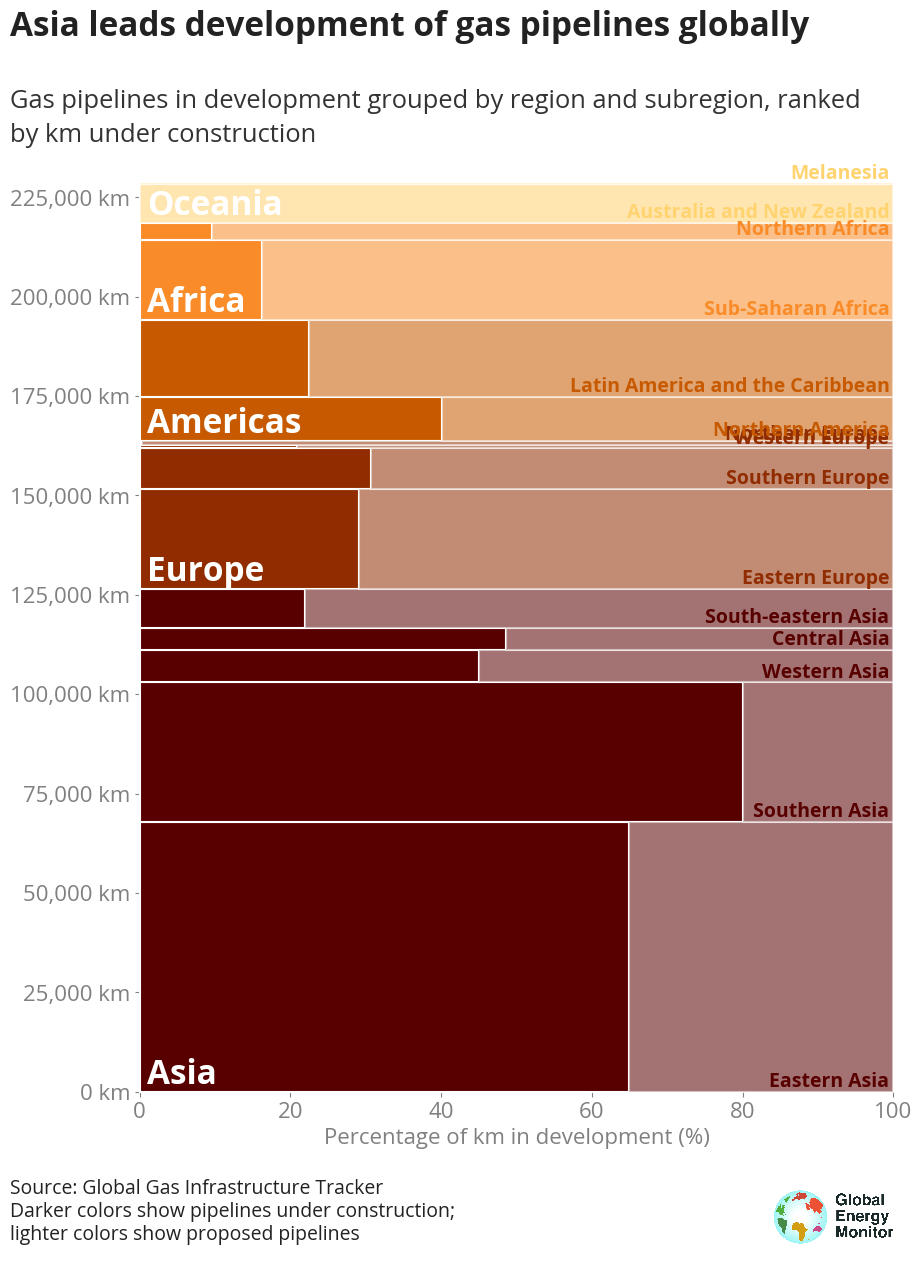

In [487]:
width_pixels = 700 # 640 default
height_pixels = 850 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
axis_text_color = '0.5'

nbars = bar_thickness_df.shape[0]
bar_km_cumsum = bar_thickness_km_df['Proposed+Construction'].cumsum().values
bar_lower_edges = numpy.append(numpy.array(0), bar_km_cumsum[:-1])
bar_center_points = (numpy.append(numpy.array(0), bar_km_cumsum)[1:] - numpy.append(numpy.array(0), bar_km_cumsum)[:-1])/2 +\
    numpy.append(numpy.array(0), bar_km_cumsum[:-1])

region_km_cumsum = regional_sum_df['Proposed+Construction'].cumsum().values
region_lower_edges = numpy.append(numpy.array(0), region_km_cumsum[:-1])
region_center_points = (numpy.append(numpy.array(0), region_km_cumsum)[1:] - numpy.append(numpy.array(0), region_km_cumsum)[:-1])/2 +\
    numpy.append(numpy.array(0), region_km_cumsum[:-1])

ax = fig.add_subplot(111)

ax.barh(y=bar_lower_edges,
        align='edge',
        width=bar_percentage_width_df.Construction,
        height=bar_thickness_km_df['Proposed+Construction'].values,
        edgecolor='1',
        linewidth=1.5,
        color=bar_thickness_km_df['Colors'].tolist(),
        left=0,
        clip_on=False)

ax.barh(y=bar_lower_edges,
        align='edge',
        width=bar_percentage_width_df.Proposed,
        height=bar_thickness_km_df['Proposed+Construction'].values,
        edgecolor='1',
        linewidth=1.5,
        color=bar_thickness_km_df['Colors'].tolist(),
        alpha=0.55,
        left=bar_percentage_width_df.Construction,
        clip_on=False)

for i in range(nbars):
    ax.text(s=bar_thickness_km_df.index.get_level_values('Subregion').tolist()[i],
            x=99.5,
            y=bar_lower_edges[i]+0.01,
            ha='right',
            va='bottom',
            color=bar_thickness_km_df['Colors'].tolist()[i],
            size=base_size*0.875,
            weight=text_weight_bold)

for i in range(region_list.__len__()):
    ax.text(s=region_order[i],
            x=1,
            y=region_lower_edges[i]+0.005,#region_center_points[i],
            ha='left',
            va='bottom',
            size=base_size*1.5,
            color='1',
            weight=text_weight_bold)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(labelsize=base_size,
               color=axis_text_color,
               labelcolor=axis_text_color,)

# format axis to have proper units and commas in thousands place
ax.yaxis.set_ticks(numpy.arange(0,ax.get_ylim()[1],25000))
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f} km'))
ax.set_ylim(0,bar_thickness_km_df.sum().values[0])
ax.set_xlim(0,100.)
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2)) # 2 for dividing major ticks into 2

ax.set_axisbelow(True)

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox() #ax.get_yticklabels()[-1].get_window_extent()
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='Gas pipelines in development grouped by region and subregion, ranked\nby km under construction',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=y_location+0.05,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=False)

bbox_with_subtitle = ax.get_tightbbox()
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='Asia leads development of gas pipelines globally',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle+0.05,#1.2,
        ha='left',
        va='bottom',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

ax.set_xlabel('Percentage of km in development (%)',
              size=base_size, color=axis_text_color)

# LEGEND AND GEM LOGO
ax.legend(fontsize=base_size,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.25)

gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,2.5), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# note at bottom
ax.text(s='Source: Global Gas Infrastructure Tracker\nDarker colors show pipelines under construction;\nlighter colors show proposed pipelines',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.25*450/height_pixels,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

# ax.tick_params(labelsize=font_size)
# ax.set_ylabel('km of pipelines in development', size=font_size)
# ax.set_xlabel('Fraction of pipelines under construction (left)\nand proposed (right)', size=font_size)

## figure 1 - tree map alternative

In [488]:
km_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Africa,"22,634.500","1,769.930","24,404.430","1,491.930",817.960,"32,001.220",0.000,"1,107.390",0.000
Americas,"25,662.600","4,685.840","30,348.440","6,553.440","22,999.470","461,688.150",381.000,224.000,0.000
Asia,"68,910.510","57,635.950","126,546.460","8,094.240","27,084.570","250,659.780",0.000,"1,373.590",229.680
Europe,"31,650.120","5,569.700","37,219.820","6,387.710","16,054.010","223,190.200","1,660.000","5,225.100","3,182.270"
Oceania,"10,176.640",4.300,"10,180.940","4,126.220","7,515.500","32,754.310",0.000,0.000,0.000


## figure 1 - tree map with improved labels

In [489]:
km_by_subregion_df_toplot

Proposed  Construction  \
Region   Subregion                                                  
Asia     Eastern Asia                    37,446.810    30,365.160   
         Southern Asia                   12,731.610    22,425.640   
         Western Asia                     6,015.840     2,153.520   
         Central Asia                     3,867.220     1,604.330   
         South-eastern Asia               8,849.030     1,087.300   
Europe   Eastern Europe                  21,303.580     3,830.210   
         Southern Europe                  8,526.750     1,656.290   
         Western Europe                     708.300        82.000   
         Northern Europe                  1,111.490         1.200   
Americas Northern America                 8,571.630     2,515.840   
         Latin America and the Caribbean 17,090.970     2,170.000   
Africa   Sub-Saharan Africa              18,561.800     1,582.000   
         Northern Africa                  4,072.700       187.930   
Oceania  Australia and New Zealand        9,856.640         4.300   
         Melanesia                          320.000         0.000   
         Micronesia                           0.000         0.000   
         Polynesia                            0.000         0.000   

                                          Proposed+Construction   Shelved  \
Region   Subregion                                                          
Asia     Eastern Asia                                67,811.970 1,784.070   
         Southern Asia                               35,157.250 1,752.000   
         Western Asia                                 8,169.360 1,845.760   
         Central Asia                                 5,471.550     0.000   
         South-eastern Asia                           9,936.330 2,712.410   
Europe   Eastern Europe                              25,133.790 4,553.920   
         Southern Europe                             10,183.040   764.540   
         Western Europe                                 790.300    69.250   
         Northern Europe                              1,112.690 1,000.000   
Americas Northern America                            11,087.470 3,456.390   
         Latin America and the Caribbean             19,260.970 3,097.050   
Africa   Sub-Saharan Africa                          20,143.800 1,319.720   
         Northern Africa                              4,260.630   172.210   
Oceania  Australia and New Zealand                    9,860.940 3,726.220   
         Melanesia                                      320.000   400.000   
         Micronesia                                       0.000     0.000   
         Polynesia                                        0.000     0.000   

                                          Cancelled   Operating      Idle  \
Region   Subregion                                                          
Asia     Eastern Asia                     2,827.380 127,567.050     0.000   
         Southern Asia                   10,509.970  39,861.300     0.000   
         Western Asia                     9,827.630  36,466.830     0.000   
         Central Asia                     2,590.590  29,099.490     0.000   
         South-eastern Asia               1,329.000  17,665.110     0.000   
Europe   Eastern Europe                   8,475.950 141,231.720 1,651.650   
         Southern Europe                  4,436.090  27,759.830     0.000   
         Western Europe                   2,138.200  28,610.480     8.350   
         Northern Europe                  1,003.770  25,588.170     0.000   
Americas Northern America                20,654.810 401,851.870    50.000   
         Latin America and the Caribbean  2,344.660  59,836.280   331.000   
Africa   Sub-Saharan Africa                 228.960   7,141.520     0.000   
         Northern Africa                    589.000  24,859.700     0.000   
Oceania  Australia and New Zealand        7,214.680  32,038.310     0.000   
         Melanesia                 

Asia
Europe
Americas
Africa
Oceania


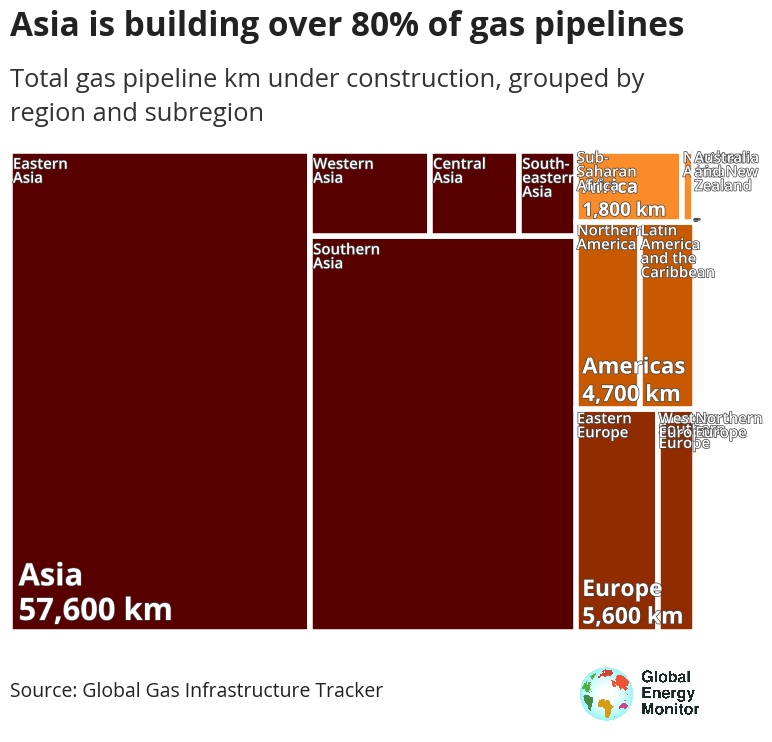

In [490]:
width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
axis_text_color = '0.5'

ax=fig.add_subplot(111)
ax.axis('off')

which_status = 'Construction'
subregion_divider_lw = 4
region_divider_lw = 3
divider_lc = '1'

# first normalize region sizes (computes the areas for the treemap)
normalized_region_values = squarify.normalize_sizes(regional_sum_df[which_status].values,
                                                    dx=100,
                                                    dy=100)
# squarify them now (computes where they are arranged)
squarified_region_values = squarify.squarify(normalized_region_values,
                                             x=0,
                                             y=0,
                                             dx=100,
                                             dy=100)

km_by_subregion_df_treemap = km_by_subregion_df_toplot[[which_status]].reset_index(level=1)
# remove all zero rows
#km_by_subregion_df_treemap = km_by_subregion_df_treemap.loc[km_by_subregion_df_treemap[which_status]!=0]

ax_bbox = ax.get_position()
x_scale = ax_bbox.bounds[2]
y_scale = ax_bbox.bounds[3]

#for i in [0]:#range(len(squarified_region_values)):
for i in range(len(squarified_region_values)):
    
    region_name = regional_sum_df.index.tolist()[i]
    print(region_name)

    # create region dividers
    ax_new = fig.add_axes([squarified_region_values[i]['x']/100*y_scale+ax_bbox.bounds[0],
                           squarified_region_values[i]['y']/100*y_scale+ax_bbox.bounds[1],
                           squarified_region_values[i]['dx']/100*x_scale,
                           squarified_region_values[i]['dy']/100*y_scale],
                          frameon=True,
                          transform=ax.transAxes)

    # pull out subregion values
    subregion_values_df = km_by_subregion_df_treemap.loc[region_name]
    # drop anything equal to zero
    subregion_values_df = subregion_values_df.loc[subregion_values_df[which_status]!=0]
    subregion_values = subregion_values_df.sort_values(which_status, ascending=False)[which_status].values
    
    normalized_subregion_values = squarify.normalize_sizes(subregion_values,
                                                           dx=squarified_region_values[i]['dx'],
                                                           dy=squarified_region_values[i]['dy'])

    ax_new.axis('off')
    
    #subregion squarify plot
    squarify.plot(normalized_subregion_values,
                  norm_x=100,
                  norm_y=100,
                  ax=ax_new,
                  pad=False,
                  color=[treemap_colors[region_name]]*normalized_subregion_values.__len__(),
                  linewidth=subregion_divider_lw,
                  clip_on=False,
                  edgecolor=divider_lc)

    region_text = ax_new.text(
                s=region_name+'\n'+'{x:,.0f} km'.format(x=round(km_by_region_df.loc[region_name,which_status],-2)),
                x=list((1.5,5,5,5,5))[i],
                y=1,
                #transform=ax_new.transAxes,
                ha='left',
                va='bottom',
                #wrap=True,
                size=base_size*numpy.log(normalized_region_values[i])/6.5,
                color='1',
                weight=text_weight_bold)
    region_text.set_path_effects([matplotlib.patheffects.withStroke(linewidth=1, foreground='0.25')])

    # for each region plot with subregions, get the rectangles (bars) of the subregions
    # final entry of bars is the full box of the plot, I think, so use N-1 of them...
    bars = [rect for rect in ax_new.get_children() if isinstance(rect, matplotlib.patches.Rectangle)][:-1]
    for j in range(bars.__len__()):
        # get lower left, top right corner of boxes
        x0,y0,x1,y1 = bars[j].get_bbox().x0, bars[j].get_bbox().y0, bars[j].get_bbox().x1, bars[j].get_bbox().y1
        text = ax_new.text(x=x0+0.5,y=y1-1.5,
                    s='\n'.join(
                        textwrap.wrap(
                        subregion_values_df.Subregion.tolist()[j],
                        10,
                        break_long_words=False)
                    ),
                    size=base_size*0.675,
                    color='1',
                    #rotation=90,
                    ha='left',
                    va='top',
                    weight=600,#text_weight_bold,
                    linespacing=1)
        text.set_path_effects([matplotlib.patheffects.withStroke(linewidth=1, foreground='0.25')])


# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox() #ax.get_yticklabels()[-1].get_window_extent()
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='Total gas pipeline km under construction, grouped by\nregion and subregion',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=y_location+0.05,
        ha='left',
        va='bottom',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=True)

bbox_with_subtitle = ax.get_tightbbox()
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='Asia is building over 80% of gas pipelines',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle+0.05,#1.2,
        ha='left',
        va='bottom',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

ax.set_xlabel('Percentage of km in development (%)',
              size=base_size, color=axis_text_color)

# LEGEND AND GEM LOGO
gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,1.5), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# note at bottom
ax.text(s='Source: Global Gas Infrastructure Tracker',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.125*450/height_pixels,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

fig.savefig('../figures/Figure01-construction-km-treemap-horiz-text.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)
fig.savefig('../figures/Figure01-construction-km-treemap-horiz-text.pdf', 
            bbox_inches='tight',
            transparent=False)

# fig.savefig('../figures/Figure01-construction-km-treemap-LatAm-rounding-horiz-text.png', 
#             dpi=300,
#             bbox_inches='tight',
#             transparent=False)
# fig.savefig('../figures/Figure01-construction-km-treemap-LatAm-rounding-horiz-text.pdf', 
#             bbox_inches='tight',
#             transparent=False)

# projects by country, by region

In [491]:
country_ratios_fuel_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    num_by_country_df[status] = country_ratios_fuel_df_status.groupby('ProjectID')['MergedKmByCountry'].count()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    num_by_region_df[status] = country_ratios_fuel_df_status.groupby('Region')['MergedKmByCountry'].count()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [492]:
num_by_region_df

,Proposed,Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Africa,42,5,5,6,127,0.000,2.000,0.000
Americas,122,30,30,83,432,2.000,2.000,0.000
Asia,265,175,33,48,1051,0.000,2.000,4.000
Europe,204,35,24,62,974,4.000,15.000,7.000
Oceania,23,1,13,15,96,0.000,0.000,0.000


# numbers of pipes finished in a given year

In [493]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Gas')]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [494]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['Operating'])) &
                              (pipes_started_startyear['Fuel']=='Gas')]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [495]:
# indev pipelines = Proposed or Construction or Shelved
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev.loc[(pipes_indev.Fuel=='Gas')&
                              (pipes_indev.Status.isin(['Proposed','Construction','Shelved']))].groupby('Status')['LengthMergedKm'].sum()
#pipes_indev = pipes_indev.loc[(pipes_indev.StartYearEarliest>2022)|
#                              (pipes_indev.StartYearEarliest.isna())].groupby('Status')['LengthMergedKm'].sum()

In [496]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030.loc[(pipes_indev_to2030['Fuel']=='Gas') &
                                        (pipes_indev_to2030['Status'].isin(['Proposed','Construction','Shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2023,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()


In [497]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
                                              (pipes_indev_startyear['Fuel']=='Gas')]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'], dropna=False)['LengthMergedKm'].sum(min_count=1)

In [498]:
pipes_indev_startyear.unstack()

StartYearEarliest,"2,018.000","2,019.000","2,020.000","2,021.000","2,022.000","2,023.000","2,024.000","2,025.000","2,026.000","2,027.000","2,028.000","2,029.000","2,030.000","2,031.000","2,034.000","2,035.000","2,046.000",NaN
Status,,,,,,,,,,,,,,,,,,
Construction,88.000,79.000,NaN,34.760,"12,682.610","19,743.410","7,258.240","1,910.920","1,265.000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"30,064.600"
Proposed,307.000,NaN,243.000,140.300,"3,142.440","4,953.970","10,933.800","14,059.290","8,029.290","4,963.560","4,322.610","1,027.000","7,039.780",0.000,255.000,140.000,"5,660.000","96,621.500"
Shelved,NaN,72.420,NaN,"1,716.720","2,919.000","4,854.650","3,399.520","3,674.930",163.000,150.000,"1,071.000",135.000,NaN,NaN,NaN,110.000,NaN,"8,471.650"


In [499]:
pipes_indev_startyear['Construction',2023]

19743.41

## 2023–2030 figure, go back to 2008

## future/past plot

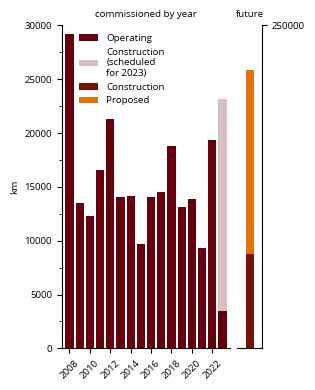

In [500]:
font_size = 7

ytop = 30000
ytop2 = 250000
xlo = 2008
xhi = 2023

fig = mp.figure(figsize=(3.25,4))

widths=[15,2.25]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.loc[range(xlo,xhi+1)].index.values, pipes_started_sum.loc[range(xlo,xhi+1)].values,
       color=tracker_operating, label='Operating') # color=solar_base03

ax.bar(2023,pipes_indev_startyear['Construction',2023],
       label='Construction\n(scheduled\nfor 2023)', bottom=pipes_started_sum.loc[2023], 
       facecolor=tracker_operating, alpha=0.25)

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(xlo-0.75, xhi+0.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,2.75)
xvals = [1.5]

colors = [tracker_construction, tracker_proposed]#, tracker_shelved]
status = ['Construction', 'Proposed']#, 'Shelved']
ax2_list = []


ax2_list.append(ax2.bar(xvals[0], pipes_indev['Construction'],
                 color=tracker_construction, label='Construction'))

ax2_list.append(ax2.bar(xvals[0], pipes_indev['Proposed']-pipes_indev_startyear['Construction',2023],
                        bottom=pipes_indev['Construction'],
                 color=tracker_shelved, label='Proposed'))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.set_yticks([250000])
ax2.set_yticklabels(['250000'])
ax2.yaxis.tick_right()

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False, 
          loc='upper left', bbox_to_anchor=[0.05,1])

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(True)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout(w_pad=0.5)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
#ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('../figures/gas-pipelines_km-by-start-year.png', bbox_inches='tight', transparent=True, dpi=300)
mp.savefig('../figures/gas-pipelines_km-by-start-year.pdf', bbox_inches='tight', transparent=True)

In [501]:
pipes_indev

Status
Construction    73,126.540
Proposed       161,838.540
Shelved         26,737.890
Name: LengthMergedKm, dtype: float64

## percent pipelines with start date (sanity check)

In [502]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Gas') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [503]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


0.4654471544715447

## regional pipelines started in given year

In [504]:
pipes_df_orig['StartYearEarliest'].min()

1904.0

In [505]:
years_array = numpy.arange(float(pipes_df_orig['StartYearEarliest'].min()), 
                           float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [506]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='oil']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='Gas')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

## figure 2 - top 15 countries proposed+construction

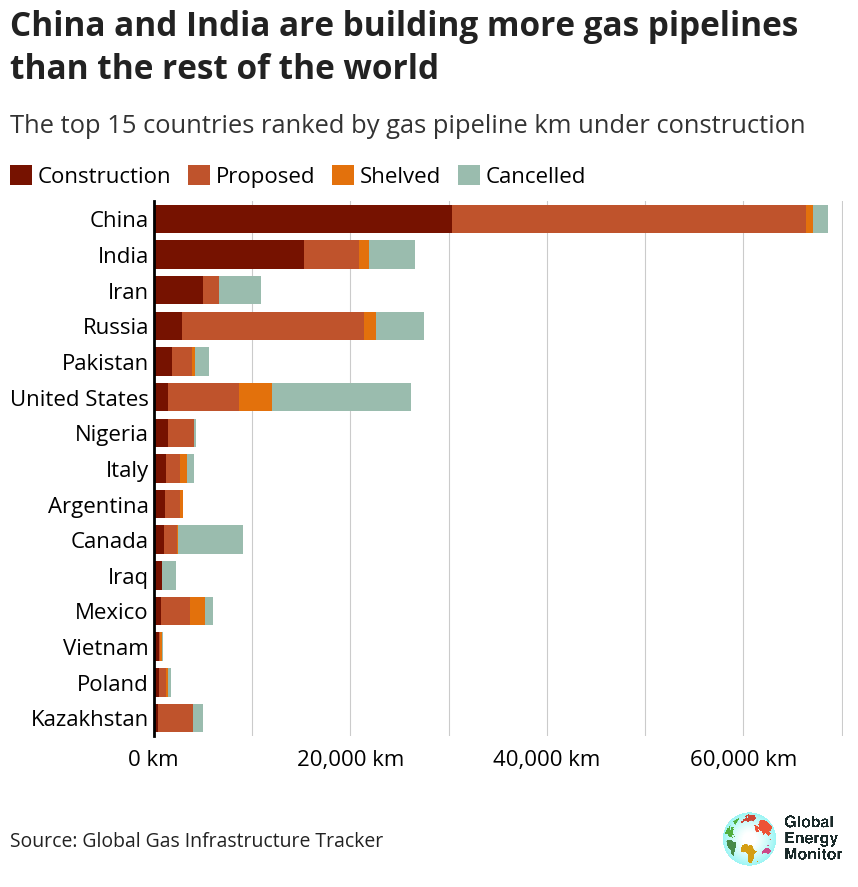

In [540]:
width_pixels = 640
height_pixels = 500
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
nbars=15

country_order = km_by_country_df.sort_values('Construction', ascending=False).index[:nbars][::-1]

ax = fig.add_subplot(111)

bar_height = 0.8

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,
        label='Proposed',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,
        label='Shelved',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,
        label='Cancelled',
        height=bar_height)

# FORMATTING
ax.tick_params(labelsize=base_size)
ax.tick_params(which='both',size=0)
ax.tick_params('x', pad=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_linewidth(2)

# format axis to have proper units and commas in thousands place
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f} km'))
ax.set_xlim(0,70100)
ax.set_ylim(-.5,nbars-.5)
ax.set_xticks([0,20000,40000,60000])

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2)) # 2 for dividing major ticks into 2
ax.xaxis.grid(which='both',
              color=color_grid)

ax.set_axisbelow(True)
ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(country_order)

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_locatio"
bbox = ax.get_tightbbox() #ax.get_yticklabels()[-1].get_window_extent()
x_location,_ = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])
legend = ax.legend(fontsize=base_size,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.25)

# now get tight bbox again for further placement AFTER legend is added
bbox = legend.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='The top 15 countries ranked by gas pipeline km under construction',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=y_location+0.05,
        ha='left',
        va='bottom',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=True)

bbox_with_subtitle = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='China and India are building more gas pipelines\nthan the rest of the world',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle+0.05,#1.2,
        ha='left',
        va='bottom',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

ax.text(s='Source: Global Gas Infrastructure Tracker',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.22*450/height_pixels, # make sure the caption adjust appropriately relative to default height of 450
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,2.15), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

mp.savefig('../figures/Figure02-gas-pipelines_top-20-countries-sorted-by-construction.png',
          bbox_inches='tight',
          transparent=False,
          dpi=300)

mp.savefig('../figures/Figure02-gas-pipelines_top-20-countries-sorted-by-construction.pdf',
          bbox_inches='tight', 
          transparent=False)

In [508]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

3.183803462487798

# parent analysis

In [509]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df.loc[(country_ratios_df.Fuel=='Gas')&(country_ratios_df.Status.isin(['Proposed','Construction']))].iterrows():
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #print(parent_string)
    if parent_string == '--':
        parent_string = 'Unknown [unknown %]'
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have an "Owner [%]" syntax, so [unknown %] is included
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]
    #print(percent_list)

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        if parent not in parents_df.index.to_list():
            parents_df.loc[parent,'ParentHQCountry']='Unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'MergedKmByCountry':row.MergedKmByCountry,
                                                                         'MergedKmByPipeline':row.MergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.MergedKmByCountry

## print out leading parent companies

In [510]:
parent_country_km_df = \
owner_parent_calculations_df.loc[#(owner_parent_calculations_df.PipelineCountry.isin(region_df_touse.Country.tolist()))&
                                 (owner_parent_calculations_df.Status.isin(['Proposed','Construction']))]

parent_country_km_df_table = pandas.DataFrame(index=parent_country_km_df.Parent.unique().tolist(),
                                             columns=['Pipeline Country Locations','Owner Headquarters Country',
                                                      'Proposed','Construction','In Development (Proposed + Construction)','ProjectIDs'])

parent_country_km_df_table['Proposed'] = parent_country_km_df.loc[parent_country_km_df.Status=='Proposed'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
parent_country_km_df_table['Construction'] = parent_country_km_df.loc[parent_country_km_df.Status=='Construction'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]

parent_country_km_df_table = parent_country_km_df_table.loc[parent_country_km_df_table.index!='']

In [511]:
pandas.options.display.max_colwidth = 500

country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).PipelineCountry.agg(lambda x: ', '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectID.agg(lambda x: ', '.join(x.unique())))
parent_country_km_df_table['Pipeline Country Locations'] = country_agg_df.PipelineCountry
parent_country_km_df_table['Number of Projects'] = owner_parent_calculations_df.groupby(['Parent']).ProjectID.count()
parent_country_km_df_table['ProjectIDs'] = projectid_agg_df.ProjectID
parent_country_km_df_table['Owner Headquarters Country'] = parent_country_km_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_km_df_table['In Development (Proposed + Construction)'] = parent_country_km_df_table[['Proposed','Construction']].sum(axis=1, min_count=0)
parent_country_km_df_table.loc[~parent_country_km_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (Proposed + Construction)', ascending=False)[:20]

,Pipeline Country Locations,Owner Headquarters Country,Proposed,Construction,In Development (Proposed + Construction),ProjectIDs,Number of Projects
"National Petroleum and Natural Gas Pipeline Network Group Co., Ltd.","China, North Korea",China,"10,165.024","14,868.644","25,033.668","P4495, P4513, P4526, P4556, P4557, P4558, P4561, P4579, P4605, P4622, P4644, P4659, P4660, P4661, P4662, P4663, P4664, P4665, P4666, P4687, P4689, P4690, P4698, P4700, P4701, P4702, P4703, P4704, P4705, P4707, P4708, P4709, P4711, P4716, P4722, P4723, P4747, P4748, P4749, P4750, P4751, P4752, P4753, P4784, P4785, P4786, P4787, P4790, P4791, P4836, P4840, P4842, P4843, P4844, P4852, P4854, P4855, P4880, P4881, P4884, P4896, P4902, P4903, P4910, P4914, P4916, P4917, P4921, P4922, P4923, P4931,...",89
Gazprom,"China, Mongolia, Russia, Bulgaria, Iran, Pakistan, Serbia",Russia,"19,056.342","2,765.417","21,821.759","P3894, P3895, P5409, P0734, P1336, P2287, P2313, P2327, P2346, P2425, P2437, P3369, P3370, P3604, P3607, P3725, P3971, P3972, P3973, P3974, P3977, P3978, P3979, P3980, P3981, P3982, P3990, P3991, P3992, P3996, P3997, P3998, P4012, P4013, P4056, P4063, P4076, P4077, P4078, P4080, P4081, P4083, P4085, P4092, P4093, P4094, P4095, P4096, P4109, P4110, P4111, P4130, P4131, P4132, P4142, P4143, P4144, P4149, P4150, P4156, P4166, P4167, P4171, P4172, P4210, P5402, P5403, P5404, P5510, P5521, P3174,...",79
GAIL (India) Limited,"Turkmenistan, Myanmar, India, Pakistan, Afghanistan, Bangladesh",India,"7,930.699","7,695.367","15,626.066","P0766, P0928, P0929, P0932, P0954, P1309, P2211, P2215, P2216, P2746, P2752, P3906, P3912",18
Iran Ministry of Petroleum,"Iran, Pakistan, Oman, Azerbaijan",Iran,400.000,"6,137.000","6,537.000","P0441, P0448, P0452, P2225, P5984, P6006, P6009",10
Nigerian National Petroleum Corporation,"Joint regime area (Senegal/Guinea Bissau), Algeria, Morocco, Western Sahara, Spain, Nigeria, Niger, The Gambia, Ghana, Liberia, Senegal, Sierra Leone, Côte d'Ivoire, Mauritania, Guinea-Bissau, Guinea",Nigeria,"4,927.638","1,427.000","6,354.638","P0463, P0460, P0488, P1313, P4185",20
Enagás,"China, Bulgaria, Greece, Albania, Italy, Spain",Spain,"4,501.947",39.732,"4,541.679","P4950, P4964, P4965, P4967, P4977, P4978, P4987, P4988, P4989, P4990, P4991, P4402, P1705, P3137, P3203, P4361, P4362, P4363, P4403, P4405, P4406, P4425",25
Transnet,"South Africa, Namibia",South Africa,"3,949.190",,"3,949.190","P2254, P2469, P2470, P2471, P2472, P2473, P2474, P3337, P3338, P3339",11
"Anhui Province Natural Gas Development Co., Ltd.",China,China,574.750,"2,524.000","3,098.750","P4580, P4582, P4583, P4584, P4585, P4586, P4589, P4590, P4591, P4592, P4593, P4594, P4596, P4598, P4600, P4603",16
TC Energy,"Mexico, Canada, United States",Canada,"1,644.500","1,292.340","2,936.840","P0434, P1268, P3921, P0167, P0243, P2005, P2530, P2556, P3186, P3187, P3188, P3189, P3279, P3609, P3611, P3613, P4446, P4447, P5416, P5547",20
Moroccan National Board of Hydrocarbons and Mines,"Joint regime area (Senegal/Guinea Bissau), Morocco, Western Sahara, Spain, The Gambia, Ghana, Liberia, Senegal, Sierra Leone, Côte d'Ivoire, Mauritania, Guinea-Bissau, Guinea",Morocco,"2,865.635",,"2,865.635",P0463,14


### how many of the projects for each owner do we have capacity data for? (add fraction)

## emissions estimates

In [512]:
# kuhne paper, for oil
co2_rate = 152.789 # number is 152,789 tCO2/year emissions per kilobarrel per day, divide by 1000 to get per bpd (bpd=BOEd)

### total emissions globally (known capacity is at about 67%)

### count fraction of available capacity information

count

In [513]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBOEd'].size()
#pipes_df_subset.groupby('StartRegion')['CapacityBcm/y'].size()

StartRegion
Africa        7
Americas    125
Asia        327
Europe      106
Oceania      17
Name: CapacityBOEd, dtype: int64

fraction

In [514]:
pandas.options.display.float_format = '{:,.3f}'.format
pandas.DataFrame(pipes_df_subset.loc[
    ~pipes_df_subset['CapacityBcm/y'].isna()].groupby(
    'StartRegion')['CapacityBcm/y'].size()/pipes_df_subset.groupby(
    'StartRegion')['CapacityBOEd'].size()).sort_values(by=0, ascending=False)

,0
StartRegion,
Americas,0.845
Asia,0.661
Oceania,0.654
Europe,0.522
Africa,0.280


In [515]:
median_capacity = pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()

In [516]:
abs_dist_from_med_capacity = abs(pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y']-
                                 pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()).median()

In [517]:
pipes_df_orig['CapacityBcm/y'].mean()

562.6159382793016

In [518]:
pipes_df_orig['CapacityBcm/y'].std()

11533.86418119282

In [519]:
print(median_capacity)
print(abs_dist_from_med_capacity)

3.5
3.02


median capacity for a pipeline is about 4.14 bcm/y

median abs dist from the median is about 3.5.

# cost estimates (pipeline cost per km)

## pick out high and low quantiles

In [520]:
temp_df = pipes_df_orig.loc[(~pipes_df_orig.CostUSDPerKm.isnull())&
                            (pipes_df_orig.Fuel=='Gas')]
qlo_val = 0.025
qhi_val = 0.975

q_lo=temp_df['CostUSDPerKm'].quantile(qlo_val)
q_hi=temp_df['CostUSDPerKm'].quantile(qhi_val)
print(temp_df['CostUSDPerKm'].quantile(qlo_val))
print(temp_df['CostUSDPerKm'].quantile(qhi_val))

temp_df = temp_df.loc[temp_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]

144334.95287
16687209.058


In [521]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.loc[(country_ratios_df['Fuel']=='Gas') & 
                                                               (country_ratios_df['CostUSDPerKm'].notna()) & 
                                                               (country_ratios_df['LengthKnownKmByCountry'].notna()) #&
                                                               #(country_ratios_df['LengthKnownKm']!=0) &
                                                               #(country_ratios_df['CostUSDPerKm']<10e6)
                                                              ]

country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df.loc[
    country_ratios_with_length_and_cost_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

In [522]:
country_ratios_df.loc[(country_ratios_df['Fuel']=='Gas') & 
                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                    (country_ratios_df['LengthKnownKmByCountry'].notna())].shape

(1034, 36)

In [523]:
country_ratios_df.loc[(country_ratios_df['Fuel']=='Gas')].shape

(4012, 36)

In [524]:
1034/4012

0.2577268195413759

### global mean value

In [525]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

2450601.7259236453

### calculate regional costs

In [526]:
region_list

['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

In [527]:
pipes_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for region in region_list:
    country_ratios_region_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['Region']==region,:]
    pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_costs_region_df.loc[region,'DataPoints'] = list(set(country_ratios_region_df['ProjectID'])).__len__()

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_4007/3912453063.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3096054.8000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()


In [528]:
pipes_costs_subregion_df = pandas.DataFrame(0, index=subregion_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for subregion in subregion_list:
    country_ratios_subregion_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['SubRegion']==subregion,:]
    pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = country_ratios_subregion_df['CostUSDPerKm'].mean()
    pipes_costs_subregion_df.loc[subregion,'DataPoints'] = list(set(country_ratios_subregion_df['ProjectID'])).__len__()

# for subregions with no data, inherit from the REGIONAL cost
for idx,row in pipes_costs_subregion_df.loc[pipes_costs_subregion_df.CostUSDPerKm.isnull()].iterrows():
    #print(pipes_costs_subregion_df.loc[idx,'CostUSDPerKm'])
    which_region = idx
    pipes_costs_subregion_df.loc[idx,'CostUSDPerKm'] = pipes_costs_region_df.loc[dict_subregion_region[which_region],'CostUSDPerKm']

pipes_costs_subregion_df.sort_values('CostUSDPerKm', ascending=False)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_4007/3870605072.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2847723.311764706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = country_ratios_subregion_df['CostUSDPerKm'].mean()


,CostUSDPerKm,DataPoints
Northern Europe,"5,757,914.647",10
Western Europe,"4,763,444.893",13
Northern America,"4,649,434.929",179
Sub-Saharan Africa,"3,928,708.954",5
Western Asia,"3,601,253.594",41
Latin America and the Caribbean,"2,958,363.579",43
Melanesia,"2,847,723.312",0
Micronesia,"2,847,723.312",0
Polynesia,"2,847,723.312",0
Australia and New Zealand,"2,847,723.312",17


In [529]:
pipes_costs_region_df

,CostUSDPerKm,DataPoints
Africa,"3,096,054.800",29
Americas,"4,308,253.867",217
Asia,"1,775,373.377",456
Europe,"2,995,574.749",134
Oceania,"2,847,723.312",17


In [530]:
country_ratios_region_df['CostUSDPerKm'].mean()

2847723.311764706

In [531]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_region_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Americas,4.308,217
Africa,3.096,29
Europe,2.996,134
Oceania,2.848,17
Asia,1.775,456


In [532]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_subregion_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Northern Europe,5.758,10
Western Europe,4.763,13
Northern America,4.649,179
Sub-Saharan Africa,3.929,5
Western Asia,3.601,41
Latin America and the Caribbean,2.958,43
Melanesia,2.848,0
Micronesia,2.848,0
Polynesia,2.848,0
Australia and New Zealand,2.848,17


# tables etc.

## table for stranded asset calculations

## country-level capex estimates

In [533]:
pipes_costs_region_df.sort_values('CostUSDPerKm', ascending=False)

,CostUSDPerKm,DataPoints
Americas,"4,308,253.867",217
Africa,"3,096,054.800",29
Europe,"2,995,574.749",134
Oceania,"2,847,723.312",17
Asia,"1,775,373.377",456


add a cost USD estimate column and estimate costs based on region and km by country

In [534]:
pipes_costs_subregion_df

,CostUSDPerKm,DataPoints
Australia and New Zealand,"2,847,723.312",17
Central Asia,"2,283,624.052",21
Eastern Asia,"1,430,084.314",374
Eastern Europe,"2,847,218.449",74
Latin America and the Caribbean,"2,958,363.579",43
Melanesia,"2,847,723.312",0
Micronesia,"2,847,723.312",0
Northern Africa,"2,653,707.281",26
Northern America,"4,649,434.929",179
Northern Europe,"5,757,914.647",10


In [535]:
country_ratios_df.reset_index(drop=True, inplace=True)
country_ratios_df.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_df.iterrows():
    # calculate cost
    cntry = row.Country
    #region = row.Region
    subregion = row.SubRegion
    km_by_cntry = row.LengthKnownKmByCountry
    #country_ratios_df.loc[idx,'CostUSDEstimate'] = pipes_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry
    country_ratios_df.loc[idx,'CostUSDEstimate'] = pipes_costs_subregion_df.loc[subregion, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()), 'LengthKnownKmByCountry'] * \
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()), 'CostUSDPerKm']

In [536]:
country_ratios_df.SubRegion.unique()

array(['Sub-Saharan Africa', 'Latin America and the Caribbean',
       'Southern Europe', 'Australia and New Zealand', 'Central Asia',
       'Eastern Asia', 'Eastern Europe', 'Melanesia', 'Northern Africa',
       'Northern America', 'Northern Europe', 'South-eastern Asia',
       'Southern Asia', 'Western Asia', 'Western Europe'], dtype=object)

In [537]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)
capex_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_df_status = country_ratios_df.loc[country_ratios_df.Status==status]
    country_ratios_df_status = country_ratios_df_status.loc[~country_ratios_df_status.SubRegion.isnull()]
    capex_by_country_df[status] = country_ratios_df_status.groupby('Country')['CostUSDEstimate'].sum()/1e9
    capex_by_region_df[status] = country_ratios_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9
    capex_by_subregion_df[status] = country_ratios_df_status.groupby(['Region','SubRegion'])['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)
capex_by_subregion_df = capex_by_subregion_df.fillna(0)

capex_by_region_df['Proposed+Construction'] = capex_by_region_df[['Proposed','Construction']].sum(axis=1)
#capex_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_region_df = capex_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
#capex_by_region_df.sort_values('Construction', ascending=False, inplace=True)
capex_by_region_df.loc['Total',:] = capex_by_region_df.sum(axis=0).values

capex_by_country_df['Proposed+Construction'] = capex_by_country_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_country_df = capex_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_country_df.sort_values('Construction', ascending=False, inplace=True)
capex_by_country_df.loc['Total',:] = capex_by_country_df.sum(axis=0).values

capex_by_subregion_df['Proposed+Construction'] = capex_by_subregion_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_subregion_df = capex_by_subregion_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
#capex_by_subregion_df.sort_values('Construction', ascending=False, inplace=True)
capex_by_subregion_df.loc['Total',:] = capex_by_subregion_df.sum(axis=0).values

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [538]:
capex_by_region_df.replace(0,'')

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Africa,86.891,11.477,98.368,0.777,11.203,155.255,,2.939,
Americas,123.380,52.194,175.575,71.874,269.532,"2,665.323",1.212,0.883,30.007
Asia,175.454,117.193,292.647,22.997,79.496,670.711,3.081,11.535,15.330
Europe,119.369,12.992,132.362,15.304,67.755,923.199,9.518,40.191,14.695
Oceania,23.983,0.049,24.032,4.275,17.988,93.747,,,0.533
Total,529.078,193.905,722.983,115.227,445.974,"4,508.234",13.810,55.547,60.564


In [539]:
capex_by_subregion_df.index = capex_by_subregion_df.index.set_names(['Region','Subregion'])
capex_by_subregion_df.replace(0,'')

Proposed Construction  \
Region   Subregion                                               
Africa   Northern Africa                   14.177        0.479   
         Sub-Saharan Africa                72.714       10.998   
Americas Latin America and the Caribbean   62.890        6.267   
         Northern America                  60.490       45.927   
Asia     Central Asia                       5.657        7.593   
         Eastern Asia                      53.399       48.326   
         South-eastern Asia                17.083        3.868   
         Southern Asia                     39.212       49.649   
         Western Asia                      60.103        7.756   
Europe   Eastern Europe                    64.796        9.777   
         Northern Europe                   13.361        0.007   
         Southern Europe                   25.117        2.818   
         Western Europe                    16.096        0.391   
Oceania  Australia and New Zealand         23.072        0.049   
         Melanesia                          0.911                
         Micronesia                                              
         Polynesia                                               
Total                                     529.078      193.905   

                                         Proposed+Construction Shelved  \
Region   Subregion                                                       
Africa   Northern Africa                                14.656   0.600   
         Sub-Saharan Africa                             83.712   0.177   
Americas Latin America and the Caribbean                69.158   7.711   
         Northern America                              106.417  64.163   
Asia     Central Asia                                   13.250   0.217   
         Eastern Asia                                  101.725   2.551   
         South-eastern Asia                             20.951   6.945   
         Southern Asia                                  88.861   4.249   
         Western Asia                                   67.859   9.035   
Europe   Eastern Europe                                 74.573   8.652   
         Northern Europe                                13.368   0.400   
         Southern Europe                                27.935   2.714   
         Western Europe                                 16.486   3.539   
Oceania  Australia and New Zealand                      23.120   3.135   
         Melanesia                                       0.911   1.139   
         Micronesia                                                      
         Polynesia                                                       
Total                                                  722.983 115.227   

                                         Cancelled Operating   Idle  \
Region   Subregion                                                    
Africa   Northern Africa                     2.749   105.202          
         Sub-Saharan Africa                  8.455    50.053          
Americas Latin America and the Caribbean    15.051   252.612  0.979   
         Northern America                  254.481 2,412.711  0.232   
Asia     Central Asia                        2.219    75.219          
         Eastern Asia                       15.624   241.899  0.066   
         South-eastern Asia                  3.624    42.713          
         Southern Asia                      28.902   120.748          
         Western Asia                       29.128   190.133  3.014   
Europe   Eastern Europe                     34.357   588.293  7.778   
         Northern Europe                     5.780   158.850  1.411   
         Southern Europe                    15.965    62.461  0.290   
         Western Europe                     11.654   113.595  0.040   
Oceania  Australia and New Zealand          17.132    90.953          
         Melanesia                           0.857     2.794          
         Micronesia             

In [343]:
capex_by_country_df = capex_by_country_df.loc[~(capex_by_country_df==0).all(axis=1)]
capex_by_country_df.to_excel('capex-by-country.xlsx')
capex_by_country_df.tail()

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Iceland,0.000,0.000,0.000,0.000,0.000,0.173,0.000,0.000,0.000
Bolivia,2.441,0.000,2.441,0.000,0.000,14.039,0.000,0.000,0.000
Ireland,0.150,0.000,0.150,0.000,0.000,0.569,0.000,0.000,0.000
Israel,0.078,0.000,0.078,0.000,0.000,2.306,0.000,0.000,0.000
Total,529.078,193.905,722.983,115.227,445.974,"4,508.234",13.810,55.547,60.564


## capex data - 15 leading countries by construction

In [541]:
country_order

Index(['Kazakhstan', 'Poland', 'Vietnam', 'Mexico', 'Iraq', 'Canada',
       'Argentina', 'Italy', 'Nigeria', 'United States', 'Pakistan', 'Russia',
       'Iran', 'India', 'China'],
      dtype='object')

In [542]:
km_by_country_df

,Region,Subregion,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,Asia,Eastern Asia,"36,090.210","30,313.360","66,403.570",731.110,"1,462.870","122,333.770",0.000,0.000,114.400
Russia,Europe,Eastern Europe,"18,444.520","2,901.930","21,346.450","1,246.650","4,904.560","113,072.590",414.270,"1,177.300","2,000.580"
India,Asia,Southern Asia,"5,573.680","15,283.000","20,856.680","1,055.000","4,671.050","19,019.420",0.000,0.000,0.000
Australia,Oceania,Australia and New Zealand,"9,856.640",4.300,"9,860.940","3,726.220","7,214.680","29,524.310",0.000,0.000,0.000
United States,Americas,Northern America,"7,237.220","1,448.000","8,685.220","3,374.580","14,090.540","340,248.820",50.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
Libya,Africa,Northern Africa,0.000,0.000,0.000,0.000,115.560,"6,243.070",0.000,0.000,0.000
Liechtenstein,Europe,Western Europe,0.000,0.000,0.000,0.000,1.900,1.290,0.000,0.000,0.000
Luxembourg,Europe,Western Europe,0.000,0.000,0.000,0.000,0.000,150.950,0.000,0.000,0.000
Macao,Asia,Eastern Asia,0.000,0.000,0.000,0.000,0.000,12.800,0.000,0.000,0.000


In [543]:
nbars = 15
country_order = km_by_country_df.sort_values('Construction', ascending=False).index.tolist()[:nbars]
capex_by_country_df.loc[country_order]

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,51.538,48.119,99.657,1.046,9.529,233.112,0.066,0.000,8.107
India,13.548,26.217,39.765,2.670,10.454,59.449,0.000,0.000,0.000
Iran,9.894,17.828,27.722,0.000,12.368,36.293,0.000,0.000,0.000
Russia,49.261,8.233,57.494,3.549,16.055,519.491,1.180,7.457,9.688
Pakistan,6.241,3.663,9.904,0.702,4.883,18.894,0.000,0.000,0.000
United States,51.614,11.457,63.071,28.666,170.009,"2,013.897",0.232,0.000,24.120
Nigeria,9.339,3.840,13.179,0.000,0.000,21.901,0.000,0.000,0.000
Italy,4.081,2.307,6.389,2.425,2.070,29.754,0.000,0.000,0.000
Argentina,10.929,4.124,15.053,1.109,0.000,63.395,0.000,0.109,0.000
Canada,8.876,34.470,43.346,35.498,84.472,398.814,0.000,0.000,5.887


## print out country-level stranded assets for report discussion

## in-dev for each country in list

# us infrastructure km and cost for Gulf Coast export buildout specifically

In [544]:
which_projectids = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                    (pipes_df_orig.Status.isin(['Proposed','Construction','Shelved']))&
                                    (pipes_df_orig.Countries=='United States')&
                                    (pipes_df_orig.AssociatedWithLNGExports=='yes')].ProjectID.tolist()

In [545]:
country_ratios_df.loc[(country_ratios_df.ProjectID.isin(which_projectids))].MergedKmByPipeline.sum()

4636.679999999999

In [546]:
country_ratios_df.loc[(country_ratios_df.ProjectID.isin(which_projectids))].CostUSDEstimate.sum()/1e9

27.79345628314301

# numbers for report

## amount already being constructed

In [350]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

0.3046160585245069

## capacity/potential emissions in development globally

In [351]:
pipes_df_subset.CapacityBOEd

1433     232.690
1442         NaN
1516     372.310
1601         NaN
1617         NaN
          ...   
3760         NaN
3761   1,954.610
3762     229.900
3770         NaN
3771     146.600
Name: CapacityBOEd, Length: 901, dtype: object

In [352]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

9.66068329 million bpd
1.4760461391958097 billion tonnes CO2


In [353]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

36.886836450000004 million bpd
5.63590285435905 billion tonnes CO2


In [354]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

46.54751974000001 million bpd
7.111948993554861 billion tonnes CO2


## total number of pipelines in dev

In [355]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))]['LengthMergedKm'].sum()

31116.13

## top 10 pipelines

## biggest pipelines that went into construction in 2022/2023

In [356]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                                                  (pipes_df_orig.Status.isin(['Construction','Operating']))&
                                                                  (pipes_df_orig.ConstructionYear.isin([2022,2023]))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

,,,LengthMergedKm
PipelineName,Status,Wiki,
West-East Gas Pipeline 4,Construction,https://www.gem.wiki/West-East_Gas_Pipeline_4,"1,745.000"
Shandong Gas Pipeline Network,Construction,https://www.gem.wiki/Yantai_LNG_Terminal_Transport_Pipeline,651.000
Gryazovets-Volkhov Gas Pipeline,Construction,https://www.gem.wiki/Gryazovets-Volkhov_Gas_Pipeline,602.000
Shandong Gas Pipeline Network,Construction,https://www.gem.wiki/Shandong_Gas_Pipeline_Network,524.500
Anhui Gas Pipeline Network,Construction,https://www.gem.wiki/Anhui_Gas_Pipeline_Network,403.000
Hubei Gas Pipeline Network,Construction,https://www.gem.wiki/Hubei_Gas_Pipeline_Network,346.400
Henan Gas Pipeline Network,Construction,https://www.gem.wiki/Henan_Gas_Pipeline_Network,330.000
Taganrog-Melitopol-Berdyansk Gas Pipeline,Construction,https://www.gem.wiki/Taganrog-Melitopol_Gas_Pipeline#Location,272.740
Chongqing Gas Pipeline Network,Construction,https://www.gem.wiki/Chongqing_Gas_Pipeline_Network,261.300


## biggest pipeline projects by name in China, rather than individual ProjectID

In [357]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                                                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                                                                  (pipes_df_orig.Countries.str.contains('China'))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

LengthMergedKm
PipelineName                                  Status       Wiki                                                                               
West-East Gas Pipeline 4                      Construction https://www.gem.wiki/West-East_Gas_Pipeline_4                             5,085.000
Xinjiang Coal-to-Gas Pipeline                 Construction https://www.gem.wiki/Xinjiang_Coal-to-Gas_Pipeline_Project                4,622.000
                                              Proposed     https://www.gem.wiki/Xinjiang_Coal-to-Gas_Pipeline_Project                3,777.000
West-East Gas Pipeline 5                      Proposed     https://www.gem.wiki/West-East_Gas_Pipeline_5                             3,200.000
Anhui Gas Pipeline Network                    Construction https://www.gem.wiki/Anhui_Gas_Pipeline_Network                           3,020.300
Sichuan–Shanghai Parallel Gas Pipeline        Construction https://www.gem.wiki/Sichuan%E2%80%93Shanghai_Parallel_Gas_Pipeline       2,467.100
Guizhou Gas Pipeline Network                  Proposed     https://www.gem.wiki/Guizhou_Gas_Pipeline_Network                         2,334.960
West-East Gas Pipeline 3                      Construction https://www.gem.wiki/West-East_Gas_Pipeline_3                             2,299.120
Jiangsu Coastal Gas Pipeline                  Proposed     https://www.gem.wiki/Jiangsu_Coastal_Gas_Pipeline                         2,070.100
Inner Mongolia Gas Pipeline Network           Proposed     https://www.gem.wiki/Inner_Mongolia_Gas_Pipeline_Network                  2,026.500
Sichuan–Shanghai Parallel Gas Pipeline        Proposed     https://www.gem.wiki/Sichuan%E2%80%93Shanghai_Parallel_Gas_Pipeline       1,812.400
Yunnan Gas Pipeline Network                   Proposed     https://www.gem.wiki/Yunnan_Gas_Pipeline_Network                          1,508.410
Shandong Gas Pipeline Network                 Construction https://www.gem.wiki/Shandong_Gas_Pipeline_Network                        1,349.500
Zhejiang Natural Gas Pipeline Network         Proposed     https://www.gem.wiki/Zhejiang_Natural_Gas_Pipeline_Network                1,232.000
Hubei Gas Pipeline Network                    Construction https://www.gem.wiki/Hubei_Gas_Pipeline_Network                           1,214.500
CNOOC Coal Gasification Transmission Pipeline Construction https://www.gem.wiki/CNOOC_Coal_Gasification_Transmission_Pipeline        1,194.000
Anhui Gas Pipeline Network                    Proposed     https://www.gem.wiki/Anhui_Gas_Pipeline_Network                           1,176.000
Tibet Natural Gas Pipeline                    Construction https://www.gem.wiki/Tibet_Natural_Gas_Pipeline                           1,153.000
Guizhou Gas Pipeline Network                  Construction https://www.gem.wiki/Guizhou_Gas_Pipeline_Network                         1,113.600

In [358]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                (pipes_df_orig.Status.isin(['Construction']))&
                (pipes_df_orig.Countries.str.contains('China'))].shape

(148, 106)

In [359]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                (pipes_df_orig.Status.isin(['Construction']))&
                (pipes_df_orig.Countries.str.contains('China'))].LengthMergedKm.mean()

234.7332432432432

## km of pipeline with 2023, 2024 start years

In [360]:
# for the key points
print(pipes_indev_startyear.loc['Construction',2023],
      pipes_indev_startyear.loc['Construction',2024])

print(pipes_indev_startyear.loc['Proposed',2023],
      pipes_indev_startyear.loc['Proposed',2024])

19743.41 7258.24
4953.97 10933.8


## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations

In [361]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Gas')]['LengthMergedKm'].sum()

234965.08

In [362]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Gas') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [363]:
country_ratios_df[(country_ratios_df['Status'].isin(['Proposed','Construction'])) &
               (country_ratios_df['Fuel']=='Oil')]['MergedKmByCountry'].sum()

31116.49

## num in dev globally, whether capacity expansions or not

In [364]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (~pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

capacity expansion projects: (49, 106)
non-zero length projects: (852, 106)


In [365]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])

print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

1737   1,251.470
1766     651.540
1772         NaN
1791     601.670
1793     312.870
1795   2,372.970
1798     361.000
1809   2,021.600
1810     346.560
1828     279.230
1844      48.130
1845   1,684.670
1850     288.800
1930     240.670
1935     372.310
1948     192.530
1956         NaN
1959     722.000
1971     601.670
1987   2,743.600
1988   2,406.670
2075     267.600
2082     962.670
2092     336.930
2101         NaN
2105   4,653.830
2135   7,213.440
2165     361.000
2169   4,653.830
2171   4,188.450
2180   1,665.820
2181   1,665.820
2182   1,665.820
2183   6,515.370
2209         NaN
2213   1,752.050
2243     962.670
2250   3,257.680
2253   3,465.600
2281      84.990
2306         NaN
2307         NaN
2371     930.770
2373         NaN
2375         NaN
2376         NaN
2414     372.310
2932   4,653.830
3245         NaN
Name: CapacityBOEd, dtype: object
                     Countries CapacityBOEd
1737             United States    1,251.470
1766                  Bulgaria      651.540
1

# delay/difficulty to build analysis

### delays in 2023

In [366]:
# how many have a start year of 2023 but haven't begun?
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                    (pipes_df_orig.StartYearEarliest==2023)].groupby(['Status'])['LengthMergedKm'].sum()

Status
Cancelled         161.170
Construction   19,743.410
Operating       3,448.410
Proposed        4,953.970
Shelved         4,854.650
Name: LengthMergedKm, dtype: float64

In [367]:
# how many have a start year of 2023 but haven't begun?
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                    (pipes_df_orig.StartYearEarliest==2023)].groupby(['Status','StartRegion'])['LengthMergedKm'].sum()

Status        StartRegion
Cancelled     Americas         101.670
              Oceania           59.500
Construction  Africa         1,470.000
              Americas       2,614.410
              Asia          12,848.250
              Europe         2,810.750
Operating     Africa           120.000
              Americas         703.200
              Asia           2,017.210
              Europe            28.000
              Oceania          580.000
Proposed      Americas         837.330
              Asia           1,006.640
              Europe         2,610.000
              Oceania          500.000
Shelved       Americas       1,553.650
              Asia           1,873.000
              Europe           843.000
              Oceania          585.000
Name: LengthMergedKm, dtype: float64

### timeline of pipeline completion

In [368]:
# timeline of pipeline completion?
# need both proposal year and needs to be operational and have a start year
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Operating')&
    (~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

,PipelineNetworkGrouping,PipelineName,SegmentName,Wiki,ProjectID,Researcher,LastUpdated,Fuel,PipelineType,Countries,...,ImpactedByRussiaUkraineInvasion,CostUSDPerKm,CostEuroPerKm,PipelineWikiGrouping,AssociatedWithLNGExports,AssociatedLNGTerminal,DraftPCI6List,PCI6ProjectCode,PipelineDirectionality,CharacterCountTooLong
443,,Tuscarora Gas Pipeline,,https://www.gem.wiki/Tuscarora_Gas_Pipeline,P0275,HK,2023-08-07,Gas,transmission,United States,...,,NaN,NaN,,,,,,,NaN
579,,Vector Gas Pipeline,,"https://www.enbridge.com/~/media/Enb/Documents/Factsheets/FS_EnergyInfrastructureAssets.pdf?la=en, https://dtmidstream.com/asset/vector-pipeline/,\nhttps://www.vector-pipeline.com/-/media/EepEeqMep/Site-Documents/Vector/News-Releases/Business-Update-Meeting-2020.pdf",P0277,HK,2023-08-03,Gas,transmission,"United States, Canada",...,,"846,350.417","776,468.272",,,,,,,NaN
749,,Dolphin Qatar–UAE Natural Gas Pipeline,,https://www.gem.wiki/Dolphin_Qatar%E2%80%93UAE_Natural_Gas_Pipeline,P0437,NA,2022-07-23,Gas,,"Qatar, United Arab Emirates, Oman",...,,"9,615,384.615","8,821,453.776",,,,,,,NaN
789,新疆管网,Zungharia Basin Rim Gas Pipeline Network,Karamay-Ürümqi New Gas Pipeline,https://www.gem.wiki/Zungharia_Basin_Rim_Gas_Pipeline_Network,P4737,BL+AY+XJ,2023-08-15,Gas,,China,...,,NaN,NaN,,,,,,,NaN
798,,Independence Trail Natural Gas Pipeline,,https://www.gem.wiki/Independence_Trail_Natural_Gas_Pipeline,P0204,HK,2023-08-25,Gas,,United States,...,,NaN,NaN,,,,,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,,Khafji Gas Pipeline,2-C Onshore,https://www.gem.wiki/Khafji_Gas_Pipeline,P5894,NA,2023-09-05,Gas,transmission,Kuwait,...,,NaN,NaN,,,,,,,NaN
2274,,Malborghetto-Flaibano Gas Pipeline,Bordano-Flaibano Expansion,https://www.gem.wiki/Malborghetto-Flaibano_Gas_Pipeline,P5553,HH,2022-08-22,Gas,,Italy,...,,NaN,NaN,,,,,,,NaN
2275,,Pontremoli–La Spezia Gas Pipeline,Capacity Expansion,https://gem.wiki/Pontremoli–La_Spezia_Gas_Pipeline,P5554,HH,2022-08-26,Gas,,Italy,...,,NaN,NaN,,,,,,,NaN
2276,,Cortemaggiore–Pontremoli Gas Pipeline,Capacity Expansion,https://gem.wiki/Cortemaggiore–Pontremoli_Gas_Pipeline,P5555,HH,2022-08-26,Gas,,Italy,...,,NaN,NaN,,,,,,,NaN


In [369]:
pipes_df_gas_with_completion_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Operating')&
    (~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')&
    (pipes_df_orig.ProposalYear!=pipes_df_orig.StartYearEarliest)]

In [370]:
pipes_df_gas_with_completion_data.shape

(64, 106)

In [371]:
numpy.array(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear).mean()

4.203125

In [372]:
# mean rate of construction (km of pipeline per year)
numpy.array(pipes_df_gas_with_completion_data.LengthMergedKm/(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)).mean()

108.30285657918466

In [373]:
numpy.array(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)

array([1.0, 3.0, 5.0, 1.0, 3.0, 1.0, 2.0, 2.0, 1.0, 4.0, 4.0, 10.0, 2.0,
       2.0, 4.0, 6.0, 4.0, 2.0, 6.0, 4.0, 4.0, 2.0, 7.0, 1.0, 1.0, 1.0,
       2.0, 3.0, 2.0, 2.0, 2.0, 4.0, 1.0, 6.0, 4.0, 2.0, 1.0, 1.0, 9.0,
       2.0, 1.0, 15.0, 6.0, 1.0, 1.0, 6.0, 5.0, 4.0, 5.0, 5.0, 3.0, 5.0,
       4.0, 1.0, 2.0, 8.0, 2.0, 11.0, 11.0, 11.0, 10.0, 10.0, 10.0, 8.0],
      dtype=object)

(array([30.,  7., 10.,  3.,  2.,  1.,  2.,  1.,  1.,  1.,  0.,  0.,  2.,
         0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   0. ,   29.6,   59.2,   88.8,  118.4,  148. ,  177.6,  207.2,
         236.8,  266.4,  296. ,  325.6,  355.2,  384.8,  414.4,  444. ,
         473.6,  503.2,  532.8,  562.4,  592. ,  621.6,  651.2,  680.8,
         710.4,  740. ,  769.6,  799.2,  828.8,  858.4,  888. ,  917.6,
         947.2,  976.8, 1006.4, 1036. , 1065.6, 1095.2, 1124.8, 1154.4,
        1184. , 1213.6, 1243.2, 1272.8, 1302.4, 1332. , 1361.6, 1391.2,
        1420.8, 1450.4, 1480. ]),
 <BarContainer object of 50 artists>)

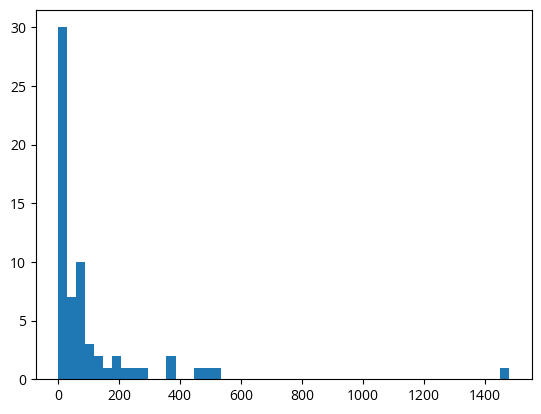

In [374]:
mp.hist(x=numpy.array(pipes_df_gas_with_completion_data.LengthMergedKm/(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)),
       bins=50)

### how long are shelved pipelines hanging around?

In [375]:
# we care about whether it's shelved, and when it was proposed
pipes_df_gas_with_shelved_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Shelved')&
    #(pipes_df_orig.ShelvedYear!='')&
    #(~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [376]:
numpy.array(2023-pipes_df_gas_with_shelved_data.ProposalYear).mean()

5.909090909090909

In [377]:
# we care about whether it's shelved, and when it was proposed
pipes_df_gas_with_shelved_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Shelved')&
    (pipes_df_orig.ShelvedYear!='')&
    #(~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [378]:
# about 22 projects right now that are marked shelved AND have a proposal year
pipes_df_gas_with_shelved_data.ShelvedYear-pipes_df_gas_with_shelved_data.ProposalYear

1536     3
1777     2
1955     2
2001     4
2317    17
2343     2
2954     2
dtype: object

In [379]:
# about 22 projects right now that are marked shelved AND have a proposal year
numpy.array(pipes_df_gas_with_shelved_data.ShelvedYear-pipes_df_gas_with_shelved_data.ProposalYear).mean()

4.571428571428571

# China, India vs rest of world

In [397]:
km_by_country_df.loc[['China','India']].Construction.sum()/km_by_country_df.Construction.sum()

0.6545020994543658

In [405]:
km_by_country_df.loc[['China','India']]['Proposed+Construction'].sum()/km_by_country_df['Proposed+Construction'].sum()

0.38154882230260595

In [403]:
km_by_country_df.loc[['China','India']].Construction.sum()

45596.36

In [404]:
km_by_country_df.Construction.sum()

69665.72

In [402]:
km_by_country_df.Construction.sum()-30313-15283

24069.72

In [399]:
km_by_country_df.loc['China'].Construction

30313.36

In [401]:
km_by_country_df.loc['India'].Construction

15283.0

In [394]:
km_by_country_df.loc[['China','India']].Construction.sum()

45596.36

In [395]:
km_by_country_df.drop(['China','India']).Construction.sum()#loc[[~'China','India']]

24069.36

In [385]:
km_by_country_df.head()

,Region,Subregion,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,Asia,Eastern Asia,"36,090.210","30,313.360","66,403.570",731.110,"1,462.870","122,333.770",0.000,0.000,114.400
Russia,Europe,Eastern Europe,"18,444.520","2,901.930","21,346.450","1,246.650","4,904.560","113,072.590",414.270,"1,177.300","2,000.580"
India,Asia,Southern Asia,"5,573.680","15,283.000","20,856.680","1,055.000","4,671.050","19,019.420",0.000,0.000,0.000
Australia,Oceania,Australia and New Zealand,"9,856.640",4.300,"9,860.940","3,726.220","7,214.680","29,524.310",0.000,0.000,0.000
United States,Americas,Northern America,"7,237.220","1,448.000","8,685.220","3,374.580","14,090.540","340,248.820",50.000,0.000,0.000
